In [1]:
import numpy as np

In [2]:
def log_or_numbers(a, b): 
         start_time = time.time() 
         mask = np.sum(b, axis=2) != 0 
         tmp = b * mask[:,:,np.newaxis] 
         a[:b.shape[0], :b.shape[1]] = a[:b.shape[0], :b.shape[1]] * np.logical_not(mask[:,:,np.newaxis]) 
         a[:b.shape[0], :b.shape[1]] = a[:b.shape[0], :b.shape[1]] + tmp 
         end_time = time.time()     
         return (end_time-start_time, a)

In [3]:
GLYPH_TABLE = [[[[0, 1, 0, 1, 0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 0, 1, 0, 1, 0],
                 [1, 1, 0, 0, 0, 1, 0, 1, 0],
                 [0, 1, 0, 1, 0, 1, 1, 0, 0]], '1'],
               [[[1, 0, 0, 0, 1, 0, 1, 0, 1],
                 [0, 0, 1, 0, 1, 0, 1, 0, 1],
                 [1, 0, 1, 0, 1, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 0, 1, 0, 0]], '2']]


def match_glyph_pattern(glyph_pattern):
    glyph_found = False
    glyph_rotation = None
    glyph_substitute = None
     
    for glyph_record in GLYPH_TABLE:
        for idx, val in enumerate(glyph_record[0]):    
            if glyph_pattern == val: 
                glyph_found = True
                glyph_rotation = idx
                glyph_substitute = glyph_record[1]
                break
        if glyph_found: break
 
    return (glyph_found, glyph_rotation, glyph_substitute)


import numpy as np
import cv2
 
def order_points(points):
 
    s = points.sum(axis=1)
    diff = np.diff(points, axis=1)
     
    ordered_points = np.zeros((4,2), dtype="float32")
 
    ordered_points[0] = points[np.argmin(s)]
    ordered_points[2] = points[np.argmax(s)]
    ordered_points[1] = points[np.argmin(diff)]
    ordered_points[3] = points[np.argmax(diff)]
 
    return ordered_points
 
def max_width_height(points):
 
    (tl, tr, br, bl) = points
 
    top_width = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    bottom_width = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    max_width = max(int(top_width), int(bottom_width))
 
    left_height = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    right_height = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    max_height = max(int(left_height), int(right_height))
 
    return (max_width,max_height)
 
def topdown_points(max_width, max_height):
    return np.array([
        [0, 0],
        [max_width-1, 0],
        [max_width-1, max_height-1],
        [0, max_height-1]], dtype="float32")
 
def get_topdown_quad(image, src):
 
    # src and dst points
    src = order_points(src)
 
    (max_width,max_height) = max_width_height(src)
    dst = topdown_points(max_width, max_height)
  
    # warp perspective
    matrix = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, matrix, max_width_height(src))
 
    # return top-down quad
    return warped
 
def add_substitute_quad(image, substitute_quad, dst):
 
    # dst (zero-set) and src points
    dst = order_points(dst)
     
    (tl, tr, br, bl) = dst
    min_x = min(int(tl[0]), int(bl[0]))
    min_y = min(int(tl[1]), int(tr[1]))
 
    for point in dst:
        point[0] = point[0] - min_x
        point[1] = point[1] - min_y
 
    (max_width,max_height) = max_width_height(dst)
    (max_width,max_height) = (max_width + 50,max_height + 50)
    src = topdown_points(max_width, max_height)
 
    # warp perspective (with white border)
    substitute_quad = cv2.resize(substitute_quad, (max_width,max_height))
 
    warped = np.zeros((max_height,max_width, 3), np.uint8)
    warped[:,:,:] = 0
 
    matrix = cv2.getPerspectiveTransform(src, dst)
    cv2.warpPerspective(substitute_quad, matrix, (max_width,max_height), warped, borderMode=cv2.BORDER_TRANSPARENT)
    
    #print(log_or_numbers(image[min_y: min_y + max_height, min_x:min_x + max_width], warped).shape)
    try:
        image[min_y: min_y + max_height, min_x:min_x + max_width] = log_or_numbers(image[min_y: min_y + max_height, min_x:min_x + max_width], warped) 
        #print(log_or_numbers(image[min_y: min_y + max_height, min_x:min_x + max_width], warped).shape)
    except Exception as e:
        print('Out of frame.')
        print(image[min_y: min_y + max_height, min_x:min_x + max_width].shape)
        print(e)
     
    return image
 
def get_glyph_pattern(image, black_threshold, white_threshold):
 
    # collect pixel from each cell (left to right, top to bottom)
    cells = []
     
    cell_half_width = int(round(image.shape[1] / 10.0))
    cell_half_height = int(round(image.shape[0] / 10.0))
 
    row1 = cell_half_height*3
    row2 = cell_half_height*5
    row3 = cell_half_height*7
    col1 = cell_half_width*3
    col2 = cell_half_width*5
    col3 = cell_half_width*7
 
    cells.append(image[row1, col1])
    cells.append(image[row1, col2])
    cells.append(image[row1, col3])
    cells.append(image[row2, col1])
    cells.append(image[row2, col2])
    cells.append(image[row2, col3])
    cells.append(image[row3, col1])
    cells.append(image[row3, col2])
    cells.append(image[row3, col3])
 
    # threshold pixels to either black or white
    for idx, val in enumerate(cells):
        if np.mean(val) < black_threshold:
            cells[idx] = 0
        elif np.mean(val) > white_threshold:
            cells[idx] = 1
        else:
            return None
 
    return cells
 
def resize_image(image, new_size):
    ratio = new_size / image.shape[1]
    return cv2.resize(image,(int(new_size),int(image.shape[0]*ratio)))
 
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rotation_matrix, (w, h))

In [6]:
import cv2
import time

cap = cv2.VideoCapture(0)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

QUADRILATERAL_POINTS = 4
SHAPE_RESIZE = 100.0
BLACK_THRESHOLD = 100
WHITE_THRESHOLD = 100
GLYPH_PATTERN = [1, 0, 0, 0, 1, 0, 1, 0, 1]

output = cv2.VideoWriter('test_video.avi',
                        cv2.VideoWriter_fourcc(*'DIVX'),
                        20,
                        (width, height))

while True:
    ret, frame = cap.read()
    
    #cv2.imshow('frame', frame)
    frame_gr = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(frame_gr, (5,5), 0)
    edges = cv2.Canny(gray, 100, 200)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    for contour in contours:
        out = cv2.drawContours(frame, contour, -1, (0, 255, 0), 5)
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01*perimeter, True)
        
        if len(approx) == QUADRILATERAL_POINTS:
            # Stage 5: Perspective warping
            topdown_quad = get_topdown_quad(gray, approx.reshape(4, 2))
            # Stage 6: Border check
            resized_shape = resize_image(topdown_quad, SHAPE_RESIZE)
            
            if resized_shape.shape[0] > 5 and resized_shape.shape[1] >5:
                if resized_shape[5, 5] > BLACK_THRESHOLD: continue
 
            # Stage 7: Glyph pattern
            glyph_found = False
            '''
            for i in range(4):
                glyph_pattern = get_glyph_pattern(resized_shape, BLACK_THRESHOLD, WHITE_THRESHOLD)
                print('pattern')
                print(glyph_pattern)
                
                if glyph_pattern == GLYPH_PATTERN: 
                    glyph_found = True
                    break

                resized_shape = rotate_image(resized_shape, 90)

            if glyph_found: 
                print(1)
                substitute_image = cv2.imread('1.png')
                image = add_substitute_quad(frame, substitute_image, approx.reshape(4, 2))
                break
            '''    
                
            glyph_pattern = get_glyph_pattern(topdown_quad, BLACK_THRESHOLD, WHITE_THRESHOLD)
            glyph_found, glyph_rotation, glyph_substitute = match_glyph_pattern(glyph_pattern)
 
            if glyph_found:

                substitute_image = cv2.imread('{}.png'.format(glyph_substitute))                 
                for _ in range(glyph_rotation):
                    substitute_image = rotate_image(substitute_image, 90)                 
                image = add_substitute_quad(frame, substitute_image, approx.reshape(4, 2))
    output.write(frame)        
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(5) & 0xFF == 27:
        break
        
cap.release()
output.release()
cv2.destroyAllWindows()

Out of frame.
(130, 132, 3)
could not broadcast input array from shape (2) into shape (130,132,3)
Out of frame.
(128, 131, 3)
could not broadcast input array from shape (2) into shape (128,131,3)
Out of frame.
(130, 133, 3)
could not broadcast input array from shape (2) into shape (130,133,3)
Out of frame.
(129, 133, 3)
could not broadcast input array from shape (2) into shape (129,133,3)
Out of frame.
(131, 133, 3)
could not broadcast input array from shape (2) into shape (131,133,3)
Out of frame.
(130, 132, 3)
could not broadcast input array from shape (2) into shape (130,132,3)
Out of frame.
(131, 133, 3)
could not broadcast input array from shape (2) into shape (131,133,3)
Out of frame.
(130, 132, 3)
could not broadcast input array from shape (2) into shape (130,132,3)
Out of frame.
(131, 134, 3)
could not broadcast input array from shape (2) into shape (131,134,3)
Out of frame.
(130, 132, 3)
could not broadcast input array from shape (2) into shape (130,132,3)
Out of frame.
(132, 

Out of frame.
(135, 135, 3)
could not broadcast input array from shape (2) into shape (135,135,3)
Out of frame.
(135, 134, 3)
could not broadcast input array from shape (2) into shape (135,134,3)
Out of frame.
(135, 135, 3)
could not broadcast input array from shape (2) into shape (135,135,3)
Out of frame.
(135, 133, 3)
could not broadcast input array from shape (2) into shape (135,133,3)
Out of frame.
(135, 135, 3)
could not broadcast input array from shape (2) into shape (135,135,3)
Out of frame.
(133, 134, 3)
could not broadcast input array from shape (2) into shape (133,134,3)
Out of frame.
(134, 135, 3)
could not broadcast input array from shape (2) into shape (134,135,3)
Out of frame.
(133, 135, 3)
could not broadcast input array from shape (2) into shape (133,135,3)
Out of frame.
(133, 134, 3)
could not broadcast input array from shape (2) into shape (133,134,3)
Out of frame.
(133, 134, 3)
could not broadcast input array from shape (2) into shape (133,134,3)
Out of frame.
(133, 

Out of frame.
(124, 127, 3)
could not broadcast input array from shape (2) into shape (124,127,3)
Out of frame.
(125, 129, 3)
could not broadcast input array from shape (2) into shape (125,129,3)
Out of frame.
(124, 127, 3)
could not broadcast input array from shape (2) into shape (124,127,3)
Out of frame.
(125, 129, 3)
could not broadcast input array from shape (2) into shape (125,129,3)
Out of frame.
(124, 128, 3)
could not broadcast input array from shape (2) into shape (124,128,3)
Out of frame.
(125, 129, 3)
could not broadcast input array from shape (2) into shape (125,129,3)
Out of frame.
(125, 127, 3)
could not broadcast input array from shape (2) into shape (125,127,3)
Out of frame.
(126, 128, 3)
could not broadcast input array from shape (2) into shape (126,128,3)
Out of frame.
(125, 127, 3)
could not broadcast input array from shape (2) into shape (125,127,3)
Out of frame.
(126, 129, 3)
could not broadcast input array from shape (2) into shape (126,129,3)
Out of frame.
(124, 

Out of frame.
(125, 127, 3)
could not broadcast input array from shape (2) into shape (125,127,3)
Out of frame.
(126, 128, 3)
could not broadcast input array from shape (2) into shape (126,128,3)
Out of frame.
(124, 128, 3)
could not broadcast input array from shape (2) into shape (124,128,3)
Out of frame.
(126, 129, 3)
could not broadcast input array from shape (2) into shape (126,129,3)
Out of frame.
(125, 128, 3)
could not broadcast input array from shape (2) into shape (125,128,3)
Out of frame.
(126, 129, 3)
could not broadcast input array from shape (2) into shape (126,129,3)
Out of frame.
(125, 128, 3)
could not broadcast input array from shape (2) into shape (125,128,3)
Out of frame.
(126, 129, 3)
could not broadcast input array from shape (2) into shape (126,129,3)
Out of frame.
(124, 129, 3)
could not broadcast input array from shape (2) into shape (124,129,3)
Out of frame.
(126, 128, 3)
could not broadcast input array from shape (2) into shape (126,128,3)
Out of frame.
(125, 

Out of frame.
(112, 110, 3)
could not broadcast input array from shape (2) into shape (112,110,3)
Out of frame.
(108, 109, 3)
could not broadcast input array from shape (2) into shape (108,109,3)
Out of frame.
(107, 108, 3)
could not broadcast input array from shape (2) into shape (107,108,3)
Out of frame.
(112, 110, 3)
could not broadcast input array from shape (2) into shape (112,110,3)
Out of frame.
(111, 109, 3)
could not broadcast input array from shape (2) into shape (111,109,3)
Out of frame.
(108, 109, 3)
could not broadcast input array from shape (2) into shape (108,109,3)
Out of frame.
(107, 108, 3)
could not broadcast input array from shape (2) into shape (107,108,3)
Out of frame.
(113, 109, 3)
could not broadcast input array from shape (2) into shape (113,109,3)
Out of frame.
(112, 107, 3)
could not broadcast input array from shape (2) into shape (112,107,3)
Out of frame.
(109, 107, 3)
could not broadcast input array from shape (2) into shape (109,107,3)
Out of frame.
(113, 

Out of frame.
(112, 114, 3)
could not broadcast input array from shape (2) into shape (112,114,3)
Out of frame.
(108, 112, 3)
could not broadcast input array from shape (2) into shape (108,112,3)
Out of frame.
(108, 111, 3)
could not broadcast input array from shape (2) into shape (108,111,3)
Out of frame.
(114, 115, 3)
could not broadcast input array from shape (2) into shape (114,115,3)
Out of frame.
(114, 114, 3)
could not broadcast input array from shape (2) into shape (114,114,3)
Out of frame.
(114, 115, 3)
could not broadcast input array from shape (2) into shape (114,115,3)
Out of frame.
(114, 114, 3)
could not broadcast input array from shape (2) into shape (114,114,3)
Out of frame.
(112, 114, 3)
could not broadcast input array from shape (2) into shape (112,114,3)
Out of frame.
(111, 113, 3)
could not broadcast input array from shape (2) into shape (111,113,3)
Out of frame.
(115, 116, 3)
could not broadcast input array from shape (2) into shape (115,116,3)
Out of frame.
(113, 

Out of frame.
(111, 112, 3)
could not broadcast input array from shape (2) into shape (111,112,3)
Out of frame.
(110, 112, 3)
could not broadcast input array from shape (2) into shape (110,112,3)
Out of frame.
(109, 111, 3)
could not broadcast input array from shape (2) into shape (109,111,3)
Out of frame.
(112, 112, 3)
could not broadcast input array from shape (2) into shape (112,112,3)
Out of frame.
(111, 111, 3)
could not broadcast input array from shape (2) into shape (111,111,3)
Out of frame.
(110, 111, 3)
could not broadcast input array from shape (2) into shape (110,111,3)
Out of frame.
(109, 111, 3)
could not broadcast input array from shape (2) into shape (109,111,3)
Out of frame.
(112, 112, 3)
could not broadcast input array from shape (2) into shape (112,112,3)
Out of frame.
(110, 111, 3)
could not broadcast input array from shape (2) into shape (110,111,3)
Out of frame.
(109, 110, 3)
could not broadcast input array from shape (2) into shape (109,110,3)
Out of frame.
(112, 

In [18]:
import cv2
import time

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

QUADRILATERAL_POINTS = 4
SHAPE_RESIZE = 100.0
BLACK_THRESHOLD = 100
WHITE_THRESHOLD = 100
GLYPH_PATTERN = [1, 0, 0, 0, 1, 0, 1, 0, 1]

output = cv2.VideoWriter('test_video.avi',
                        cv2.VideoWriter_fourcc(*'DIVX'),
                        20,
                        (width, height))

ret, frame = cap.read()
frame_gr = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(frame_gr, (5,5), 0)
edges = cv2.Canny(gray, 100, 200)
#cv2.imshow('frame', edges)

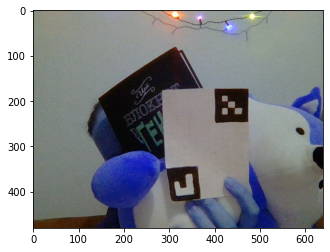

In [8]:
fig, ax = plt.subplots()
ax.imshow(frame)

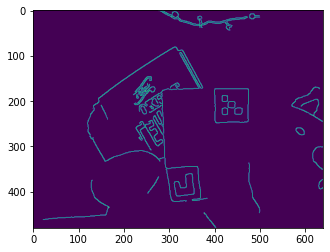

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(edges)